In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

from plot_func import *

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,integrator_tf,dynamics,run_full_plastic,probe_RFs
from dev_ori_sel_RF.tools import misc,update_params_dict,analysis_tools
import dev_ori_sel_RF.network_full_plastic as network

2023-05-03 13:39:25.821080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


In [3]:
def get_network_size(config_name):
    config_dict = misc.load_external_params("params_"+config_name)
    config_dict.update({"config_name" : config_name})

    N4 = config_dict["N4"]
    Nlgn = config_dict["Nlgn"]
    Nret = config_dict["Nret"]
    Nlgnpop = 2
    N4pop = config_dict["num_lgn_paths"] // Nlgnpop
    
    return config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4

def get_network_system(Version,config_name):
    if Version == -1:
        config_dict = misc.load_external_params("params_"+config_name,False)
        config_dict.update({
                        "RF_mode" : "initialize",
                        "system" : "one_layer",
                        "Version" : Version,
                        })
        net = network.Network(Version,config_dict,verbose=False)
    else:
        load_location = 'local'
        load_path = data_dir + "layer4/{s}/v{v}/".format(s=config_name,v=Version)
        config_dict = pickle.load(open(load_path + "config_v{v}.p".format(v=Version),"rb"))
        config_dict.update({"config_name" : config_name})
        config_dict["Wlgn_to4_params"].update({
            "W_mode": "load_from_external",
            "load_from_prev_run" : Version})
        net = network.Network(Version,config_dict,load_location=load_location,verbose=False)
    return net.system

In [14]:
reload(misc)

config_name = "full_plastic"

config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4 = get_network_size(config_name)

MISC params_dict params_full_plastic {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 16000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.0225, 'sigma2': 0.06, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.03375, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ec

In [45]:
reload(network)
_,Wlgnto4,arbor_on,arbor_off,arbor2,_,W4to4,arbor4to4,_ = get_network_system(-1,config_name)

Text(0.5, 1.0, 'LGN Off Cell (Pre)')

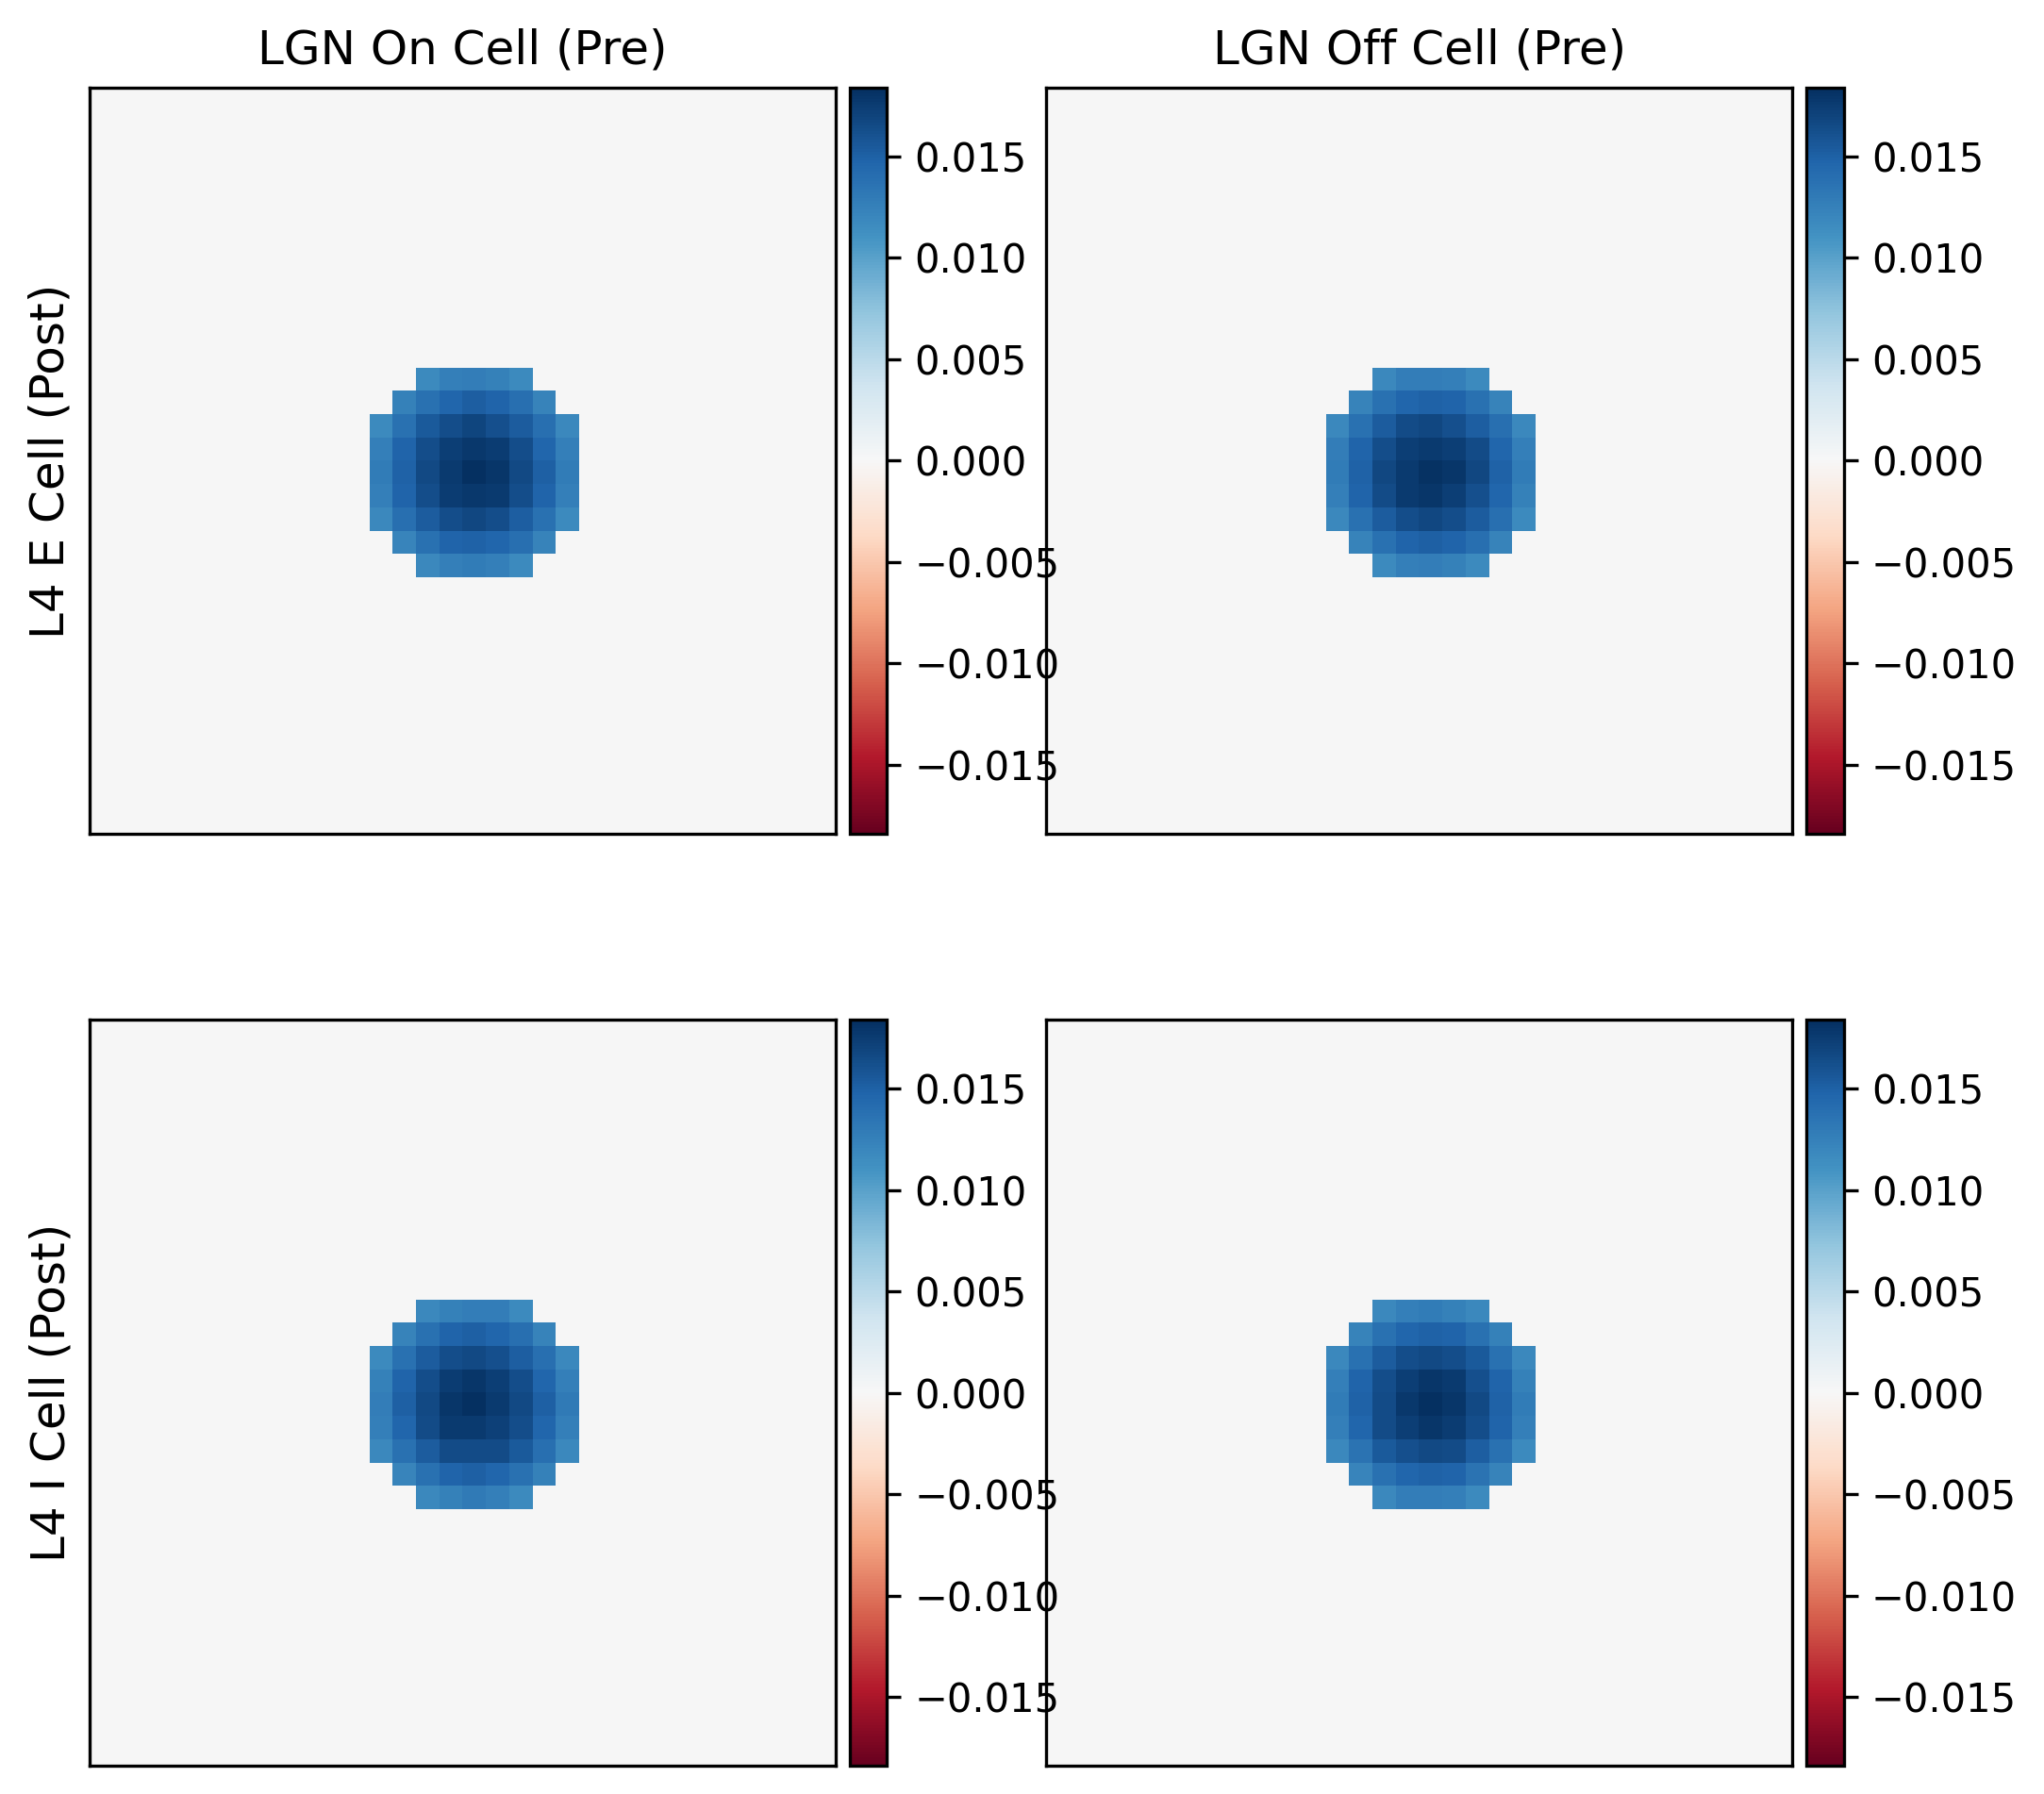

In [6]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

imshowbar(fig,axs[0,0],Wlgnto4[0].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(Wlgnto4)),vmax=np.max(np.abs(Wlgnto4)),cmap='RdBu')
imshowbar(fig,axs[0,1],Wlgnto4[1].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(Wlgnto4)),vmax=np.max(np.abs(Wlgnto4)),cmap='RdBu')
imshowbar(fig,axs[1,0],Wlgnto4[2].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(Wlgnto4)),vmax=np.max(np.abs(Wlgnto4)),cmap='RdBu')
imshowbar(fig,axs[1,1],Wlgnto4[3].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(Wlgnto4)),vmax=np.max(np.abs(Wlgnto4)),cmap='RdBu')
axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('LGN On Cell (Pre)',fontsize=12)
axs[0,1].set_title('LGN Off Cell (Pre)',fontsize=12)

3.5519999999999996
-3.1160000000000005
3.583
-3.1159999999999997


Text(0.5, 1.0, 'L4 I Cell (Pre)')

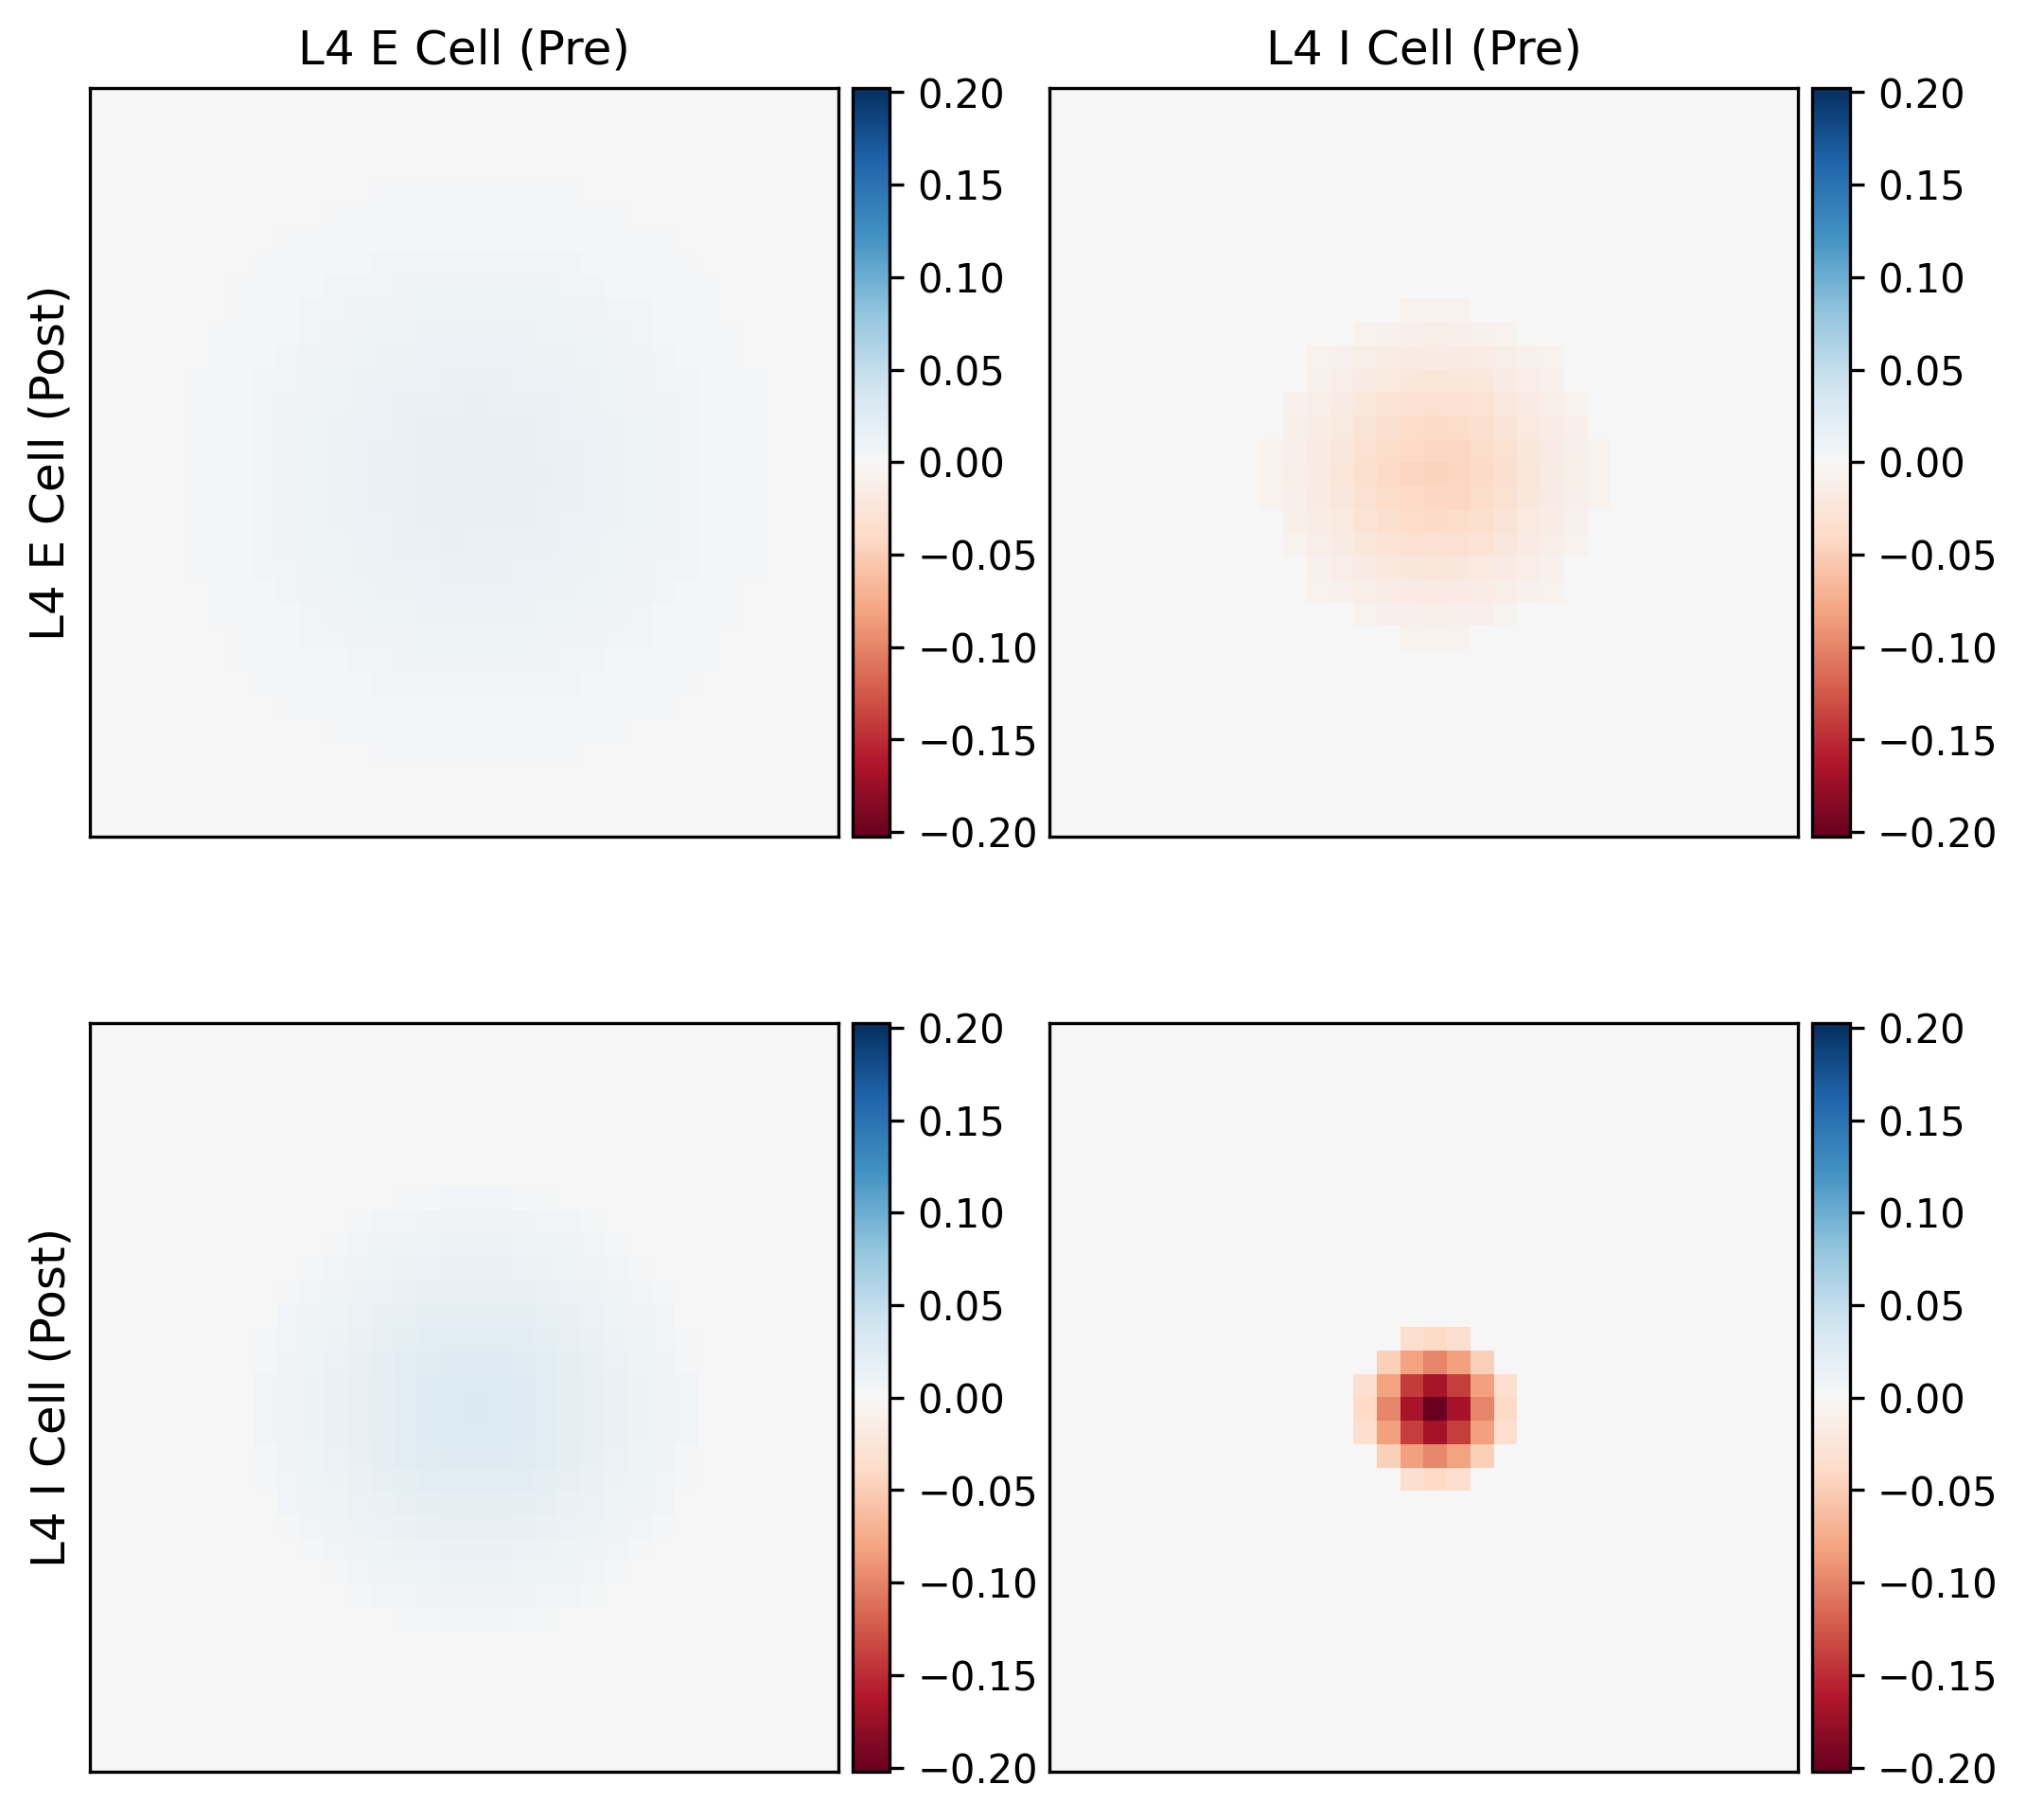

In [46]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

imshowbar(fig,axs[0,0],W4to4[:N4**2,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu')
imshowbar(fig,axs[0,1],W4to4[:N4**2,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu')
imshowbar(fig,axs[1,0],W4to4[N4**2:,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu')
imshowbar(fig,axs[1,1],W4to4[N4**2:,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu')
print(np.sum(W4to4[:N4**2,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:]))
print(np.sum(W4to4[:N4**2,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:]))
print(np.sum(W4to4[N4**2:,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:]))
print(np.sum(W4to4[N4**2:,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[N4//2,N4//2,:,:]))
axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

In [25]:
reload(misc)

<module 'dev_ori_sel_RF.tools.misc' from '/Users/tuannguyen/OrientationSSB/notebooks/./../dev_ori_sel_RF/tools/misc.py'>

In [26]:
reload(run_full_plastic)
# reload(integrator_tf)
Version = 0
run_full_plastic.parameter_sweep_layer4(Version,config_dict,not_saving_temp=False)

Please install GPU version of TF
# of stimuli: 16
mode in get_RFs initializegauss
CHECK radius 0.15
CHECK radius 0.15
mode in get_RFs initializegauss
CHECK radius 0.15
CHECK radius 0.15
mode in get_RFs initializegauss
CHECK radius 0.25
mode in get_RFs initializegauss
CHECK radius 0.25
mode in get_RFs initializegauss
CHECK radius 0.15
mode in get_RFs initializegauss
CHECK radius 0.15
W4to4 (800, 800)
constraint_vec (2398, 96800)
[Errno 2] No such file or directory: '/Users/tuannguyen/OrientationSSB/dev_ori_sel_RF/data/layer4/P_orth/N420_rec_rAon0.25_rAoff0.0_rlim2.0_gaussian.npy'
No file found for projection operator
 generating operator now...


AttributeError: 'bool' object has no attribute 'astype'